In [1]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.bitfinex_kaggle import *
from talib.abstract import *
from pprint import pprint

In [2]:
def strategy(df, config):
    ibsperiod = config["ibsperiod"]
    
    lowestlow = df.low.rolling(ibsperiod).min()
    highesthigh = df.high.rolling(ibsperiod).max()
    
    ibs = (df.close - lowestlow) / (highesthigh - lowestlow) * 100
    
    ibs_signal = ibs > config["ibsthres"]
    volume_signal = df.volume / df.volume.rolling(config["volumeperiod"]).mean()
    volume_signal = volume_signal > config["volumethres"]
    
    signal = volume_signal & ibs_signal
    
    df["enter_long"] = signal & (signal.diff() == 1)
    df["trade_cost"] = 0
    
    df["stop_loss"] = config["stop_loss"]
    df["take_profit"] = config["take_profit"]
    df["time_cut"] = config["time_cut"]
    return df

In [3]:
def backtest_and_report(config, ticker):
    data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    pprint(calc_from_order_df(order))
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

backtest completed in 0.06164193153381348 seconds
{'bothside_avg_holding_bars': 11.518817204301076,
 'bothside_profit_factor': 1.3929800197619142,
 'bothside_total_profit': 1069304.573481369,
 'bothside_total_trades': 372,
 'bothside_win_rate': 63.17204301075269,
 'buyside_avg_holding_bars': 11.518817204301076,
 'buyside_profit_factor': 1.3929800197619142,
 'buyside_total_profit': 1069304.573481369,
 'buyside_total_trades': 372,
 'buyside_win_rate': 63.17204301075269,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2016-03-09  2016-03-09
End Period                 2021-05-18  2021-05-18
Risk-Free Rate             0.0%        0.0%
Time in Market             27.0%       97.0%

Cumulative Return          10,693.05%  30,903.68%
CAGR%                      146.26%     201.73%

Sharpe                     2.38        1.3
Sortino                    4.84        2.05
Sortino/√2                 3.42        1.45

Max Drawdown               -22.1%      -93.85%
Longest DD Days            194         1101
Volatility (ann.)          27.73%      88.08%
R^2                        0.2         0.2
Calmar                     6.62        2.15
Skew                       1.78        0.37
Kurtosis                   25.58       5.46

Expected Daily %           0.25%       0.3%
Expected Monthly %         7.71%       9.53%
Expected Yearly %          118.2%      160.16%
Kelly Criterion            29.3

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-03-14,2016-06-06,2016-06-22,100,-22.103216,-20.879212
2,2017-11-29,2017-12-03,2018-04-12,134,-14.163360,-11.245919
3,2019-07-07,2019-09-01,2019-10-25,110,-12.934351,-12.644680
4,2020-09-17,2020-10-20,2020-12-28,102,-11.169217,-11.145249
5,2018-12-30,2019-01-01,2019-02-08,40,-10.048487,-9.559858


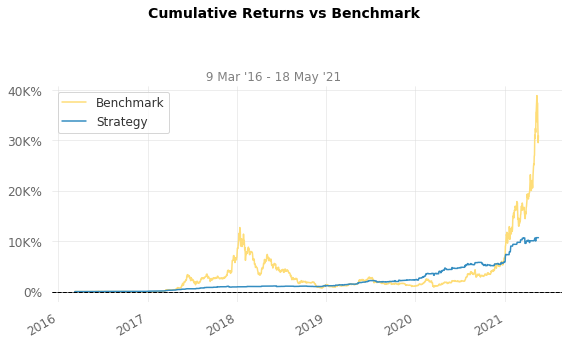

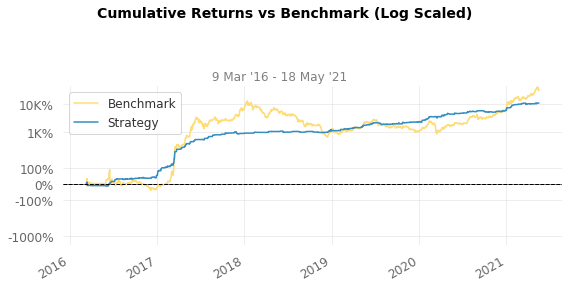

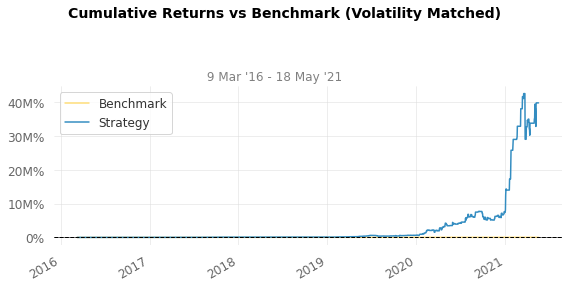

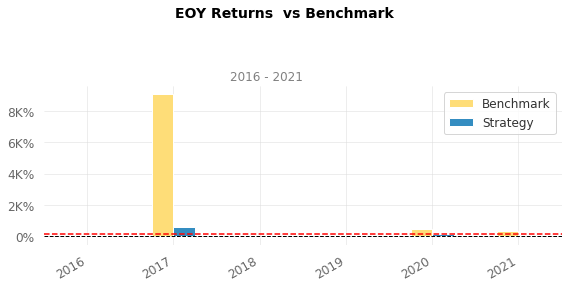

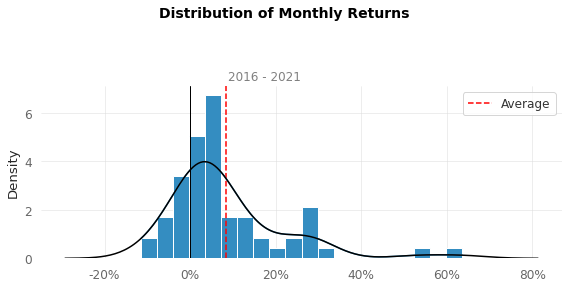

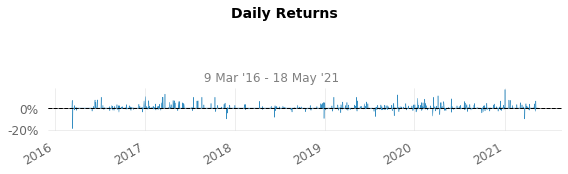

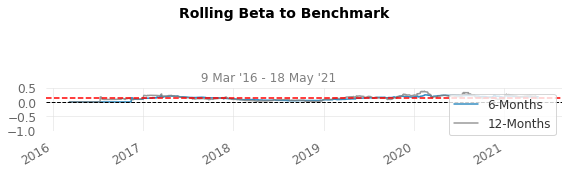

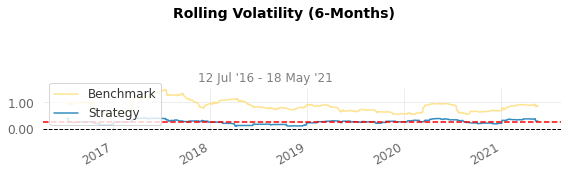

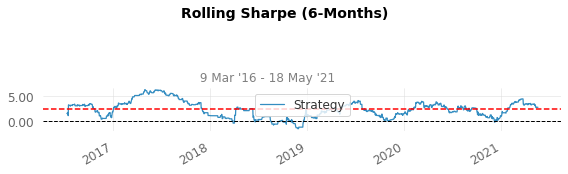

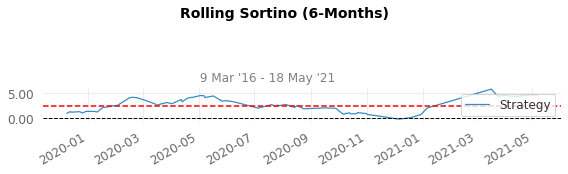

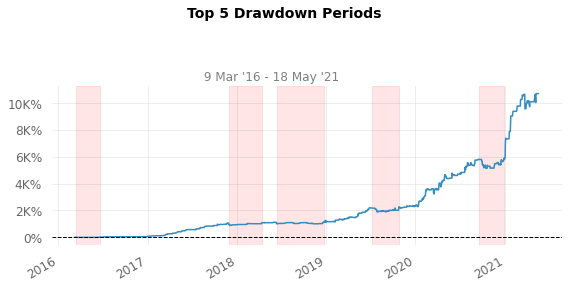

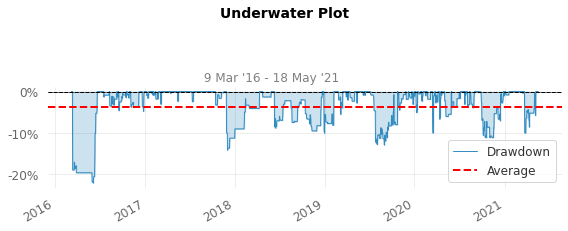

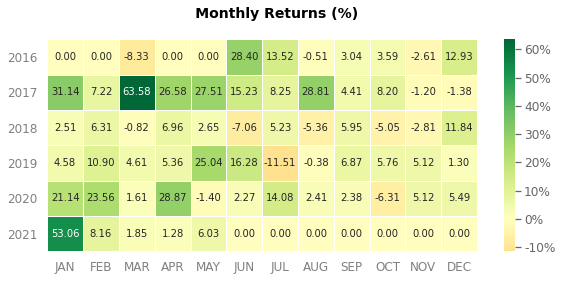

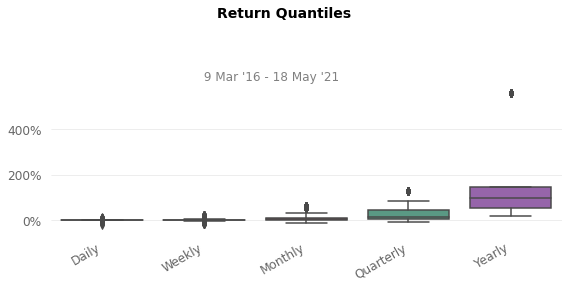

In [29]:
DEFAULT_CONFIG = {
    'time_cut': 12,
    'stop_loss': 0.1,
    'take_profit': 0.1,
    'ibsperiod' : 24,
    'ibsthres' : 70,
    'volumeperiod' : 24,
    'volumethres' : 4,
}

backtest_and_report(DEFAULT_CONFIG, "ETHUSD")

backtest completed in 0.09476327896118164 seconds
{'bothside_avg_holding_bars': 19.122222222222224,
 'bothside_profit_factor': 1.4990445337585385,
 'bothside_total_profit': 1846937.6081423562,
 'bothside_total_trades': 540,
 'bothside_win_rate': 52.59259259259259,
 'buyside_avg_holding_bars': 19.122222222222224,
 'buyside_profit_factor': 1.4990445337585385,
 'buyside_total_profit': 1846937.6081423562,
 'buyside_total_trades': 540,
 'buyside_win_rate': 52.59259259259259,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-04-01  2013-04-01
End Period                 2021-05-18  2021-05-18
Risk-Free Rate             0.0%        0.0%
Time in Market             31.0%       96.0%

Cumulative Return          18,469.38%  42,377.88%
CAGR%                      90.07%      110.43%

Sharpe                     2.01        1.08
Sortino                    5.6         1.64
Sortino/√2                 3.96        1.16

Max Drawdown               -14.17%     -84.25%
Longest DD Days            184         1126
Volatility (ann.)          23.3%       70.08%
R^2                        0.13        0.13
Calmar                     6.36        1.31
Skew                       5.06        0.21
Kurtosis                   40.25       10.41

Expected Daily %           0.18%       0.2%
Expected Monthly %         5.48%       6.37%
Expected Yearly %          78.69%      95.89%
Kelly Criterion            26

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2013-04-27,2013-06-18,2013-08-14,109,-14.165801,-13.937797
2,2020-02-19,2020-04-02,2020-04-29,70,-13.514188,-11.749171
3,2014-03-09,2014-05-11,2014-05-25,77,-13.100141,-12.873533
4,2019-04-06,2019-05-07,2019-05-19,43,-9.779733,-9.297830
5,2020-05-17,2020-11-04,2020-11-17,184,-9.557850,-8.873861


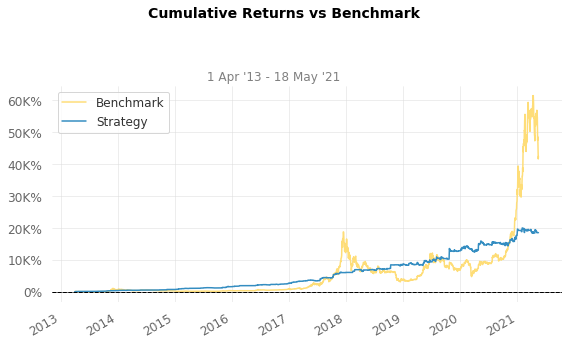

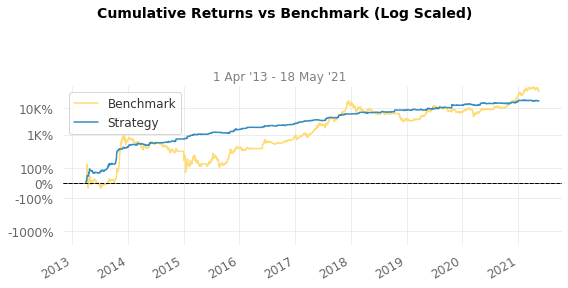

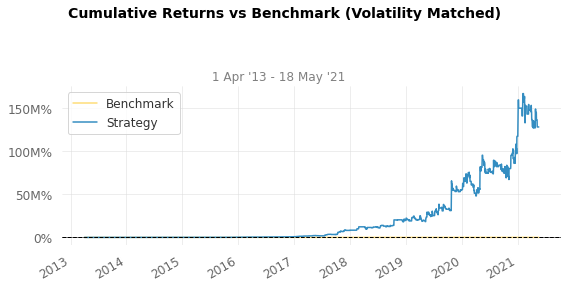

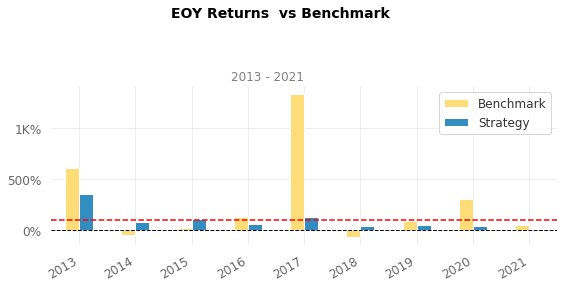

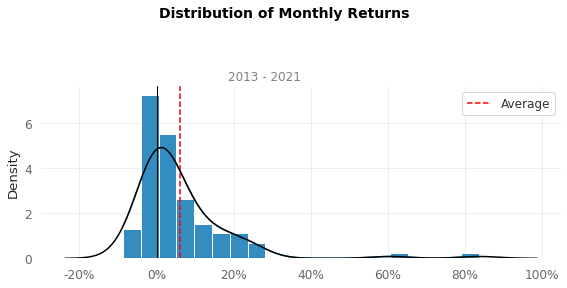

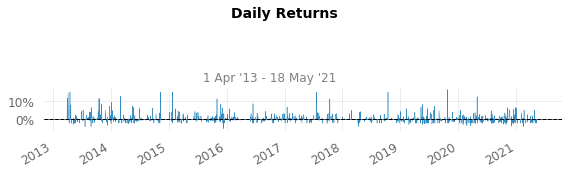

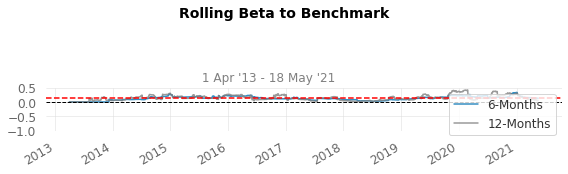

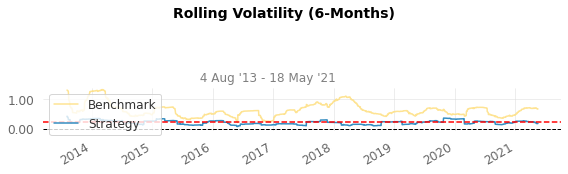

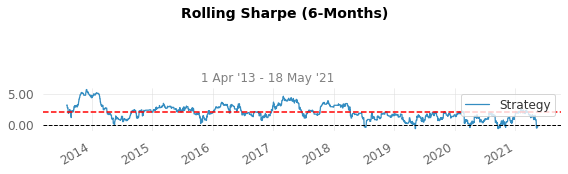

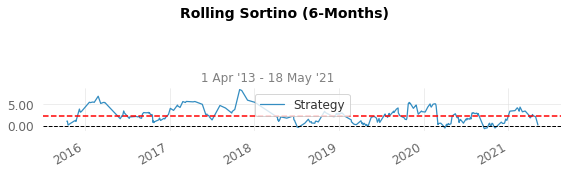

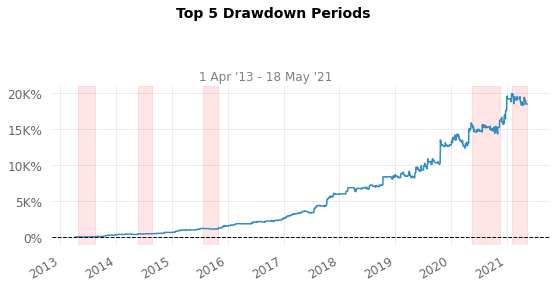

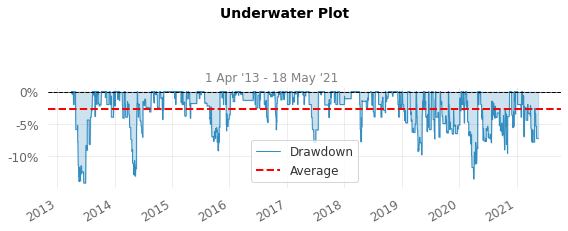

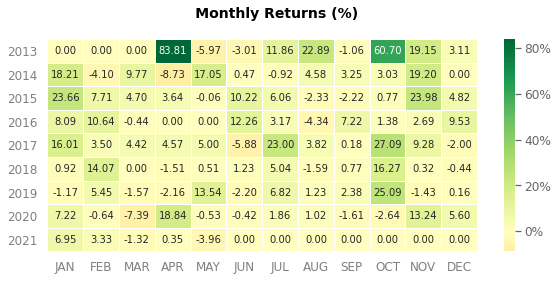

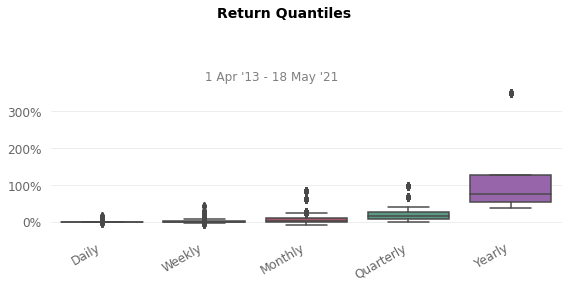

In [27]:
DEFAULT_CONFIG = {'ibsperiod': 24,
 'ibsthres': 70,
 'stop_loss': 0.02,
 'take_profit': 0.15,
 'time_cut': 24,
 'volumeperiod': 24,
 'volumethres': 4}

backtest_and_report(DEFAULT_CONFIG, "BTCUSD")

In [6]:
import ray
from ray import tune
def optimizer(config, df):
    df = df.copy()
    order_df, port_df = run_backtest_df(strategy(df, config))
    tune.report(sortino=qs.stats.calmar(port_df["portfolio_value"].resample("1D").last()))

def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "time_cut" : tune.grid_search([12, 24, 48]),
            "stop_loss" : tune.grid_search([0.02, 0.03, 0.05]),
            "take_profit" : tune.grid_search([0.05, 0.1, 0.15, 0.2]),
            'ibsperiod' : tune.grid_search([12, 24, 48]),
            'ibsthres' : tune.grid_search([70, 80, 90]),
            'volumeperiod' : tune.grid_search([6, 12, 24]),
            'volumethres' : tune.grid_search([3, 4, 5]),
        },
        local_dir="./ray_results",
    )
    return result

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [7]:
ray.init()

2021-05-27 00:14:00,329	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8269


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:30228',
 'object_store_address': '/tmp/ray/session_2021-05-27_00-13-59_201187_929698/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-27_00-13-59_201187_929698/sockets/raylet',
 'webui_url': '127.0.0.1:8269',
 'session_dir': '/tmp/ray/session_2021-05-27_00-13-59_201187_929698',
 'metrics_export_port': 58583,
 'node_id': '107d705897499d74ac9de95c5150a2ef089953528b8a6868fd570fc1'}

In [8]:
data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", "BTCUSD")
data = data.backtest.add_defaults()

In [9]:
data = data[:int(data.index.__len__() * 0.7)]

In [ ]:
result = optimize(data)

In [13]:
result = tune.Analysis("/home/ych/PycharmProjects/DeepCrypto/notebooks/ray_results/optimizer_2021-05-27_00-14-02")

In [14]:
result.get_best_config("sortino", mode="max")

{'ibsperiod': 24,
 'ibsthres': 70,
 'stop_loss': 0.02,
 'take_profit': 0.15,
 'time_cut': 24,
 'volumeperiod': 24,
 'volumethres': 5}